In [1]:
# Source : https://noureldinalaa.github.io/capsuleNetwork/
# Pas tout a été copié
# import resources
import numpy as np
import torch
import onnx
import torch.onnx
import torch.nn as nn
import torch.nn.functional as F

# random seed (for reproducibility)
seed = 1
# set random seed for numpy23
np.random.seed(seed)
# set random seed for pytorch
torch.manual_seed(seed)

In [2]:
import os
import glob
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision.transforms import ToTensor
from torchvision.transforms import transforms
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image

# Revenir au dossier parent et définir le chemin vers le dataset
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
dataset_dir = os.path.join(os.getcwd(), "fichier")

# Vérifier si le dossier existe
if not os.path.exists(dataset_dir):
    raise ValueError(f"Le dossier {dataset_dir} n'existe pas. Vérifiez le chemin.")

# Obtenir tous les fichiers TIF
image_paths = glob.glob(os.path.join(dataset_dir, "*.TIF"))
print(f"Nombre de fichiers trouvés : {len(image_paths)}")
if len(image_paths) == 0:
    raise ValueError(f"Aucun fichier .TIF trouvé dans {dataset_dir}. Vérifiez le chemin ou les fichiers.")

# Diviser les données en ensembles d'entraînement et de test
train_paths, test_paths = train_test_split(image_paths, test_size=0.2, random_state=42)

# Transformation pour convertir les images en tenseurs
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to 128x128
    transforms.ToTensor()
])


# Créer les datasets d'entraînement et de test
# Modifier la classe SIMCEPDataset pour retourner aussi le nom du fichier
class SIMCEPDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('L')  # Charger l'image en niveaux de gris
        if self.transform:
            image = self.transform(image)
        filename = os.path.basename(image_path)
        label = int(filename.split('_')[2][1:])  # Extraire "number_points" après "C"
        return image, label, filename  # Retourner aussi le nom du fichier

# Itérer sur les DataLoaders pour afficher les noms des fichiers

train_dataset = SIMCEPDataset(train_paths, transform=transform)
test_dataset = SIMCEPDataset(test_paths, transform=transform)

# Créer les DataLoaders
batch_size = 20
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Nombre d'images dans le jeu d'entraînement : {len(train_dataset)}")
print(f"Nombre d'images dans le jeu de test : {len(test_dataset)}")


ValueError: Le dossier /home/skan234401/IMT Atlantique/Projet entreprise/cobalt/CapsuleNetworks/fichier n'existe pas. Vérifiez le chemin.

In [5]:
print("\nFichiers dans le jeu de test :")
for _, _, filenames in test_loader:
    for filename in filenames:
        print(filename)


Fichiers dans le jeu de test :
SIMCEPImages_A24_C100_F1_s01_w2.TIF
SIMCEPImages_A08_C31_F1_s23_w1.TIF
SIMCEPImages_A10_C40_F1_s07_w1.TIF
SIMCEPImages_A02_C5_F1_s03_w1.TIF
SIMCEPImages_A15_C61_F1_s18_w2.TIF
SIMCEPImages_A24_C100_F1_s04_w2.TIF
SIMCEPImages_A17_C70_F1_s11_w1.TIF
SIMCEPImages_A10_C40_F1_s03_w1.TIF
SIMCEPImages_A05_C18_F1_s02_w1.TIF
SIMCEPImages_A11_C44_F1_s20_w2.TIF
SIMCEPImages_A01_C1_F1_s10_w1.TIF
SIMCEPImages_A08_C31_F1_s12_w1.TIF
SIMCEPImages_A19_C78_F1_s10_w1.TIF
SIMCEPImages_A02_C5_F1_s07_w1.TIF
SIMCEPImages_A01_C1_F1_s02_w1.TIF
SIMCEPImages_A22_C91_F1_s17_w2.TIF
SIMCEPImages_A12_C48_F1_s10_w1.TIF
SIMCEPImages_A15_C61_F1_s25_w1.TIF
SIMCEPImages_A20_C83_F1_s11_w1.TIF
SIMCEPImages_A16_C66_F1_s19_w2.TIF
SIMCEPImages_A03_C10_F1_s06_w2.TIF
SIMCEPImages_A18_C74_F1_s22_w2.TIF
SIMCEPImages_A18_C74_F1_s13_w2.TIF
SIMCEPImages_A13_C53_F1_s22_w1.TIF
SIMCEPImages_A07_C27_F1_s02_w1.TIF
SIMCEPImages_A24_C100_F1_s13_w1.TIF
SIMCEPImages_A21_C87_F1_s11_w2.TIF
SIMCEPImages_A16_C66_F1_

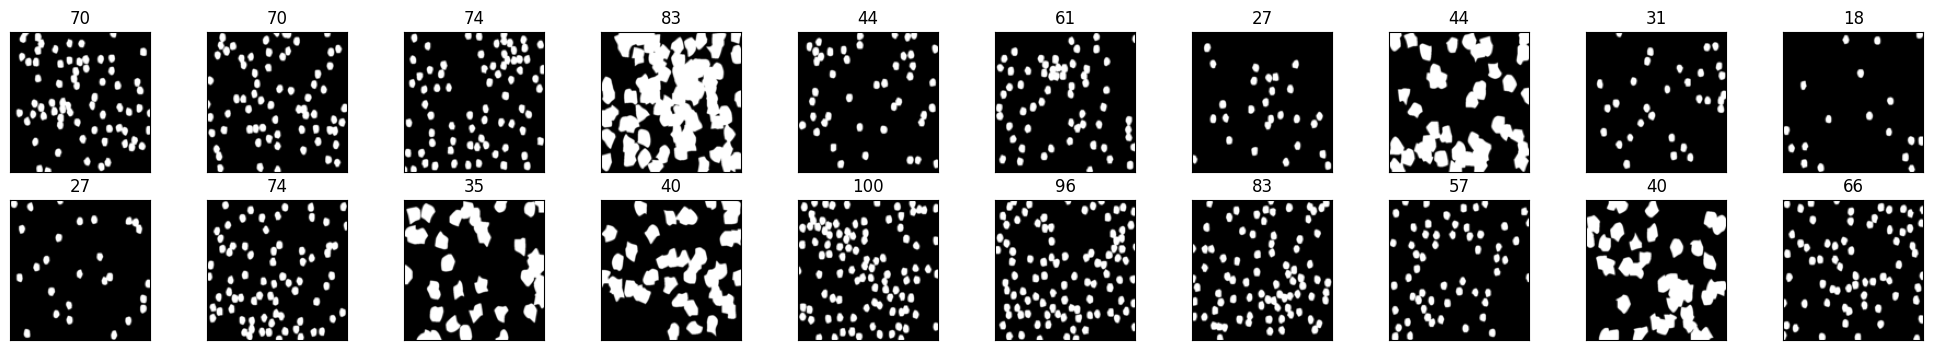

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming train_loader is defined and ready
dataiter = iter(train_loader)

# Use the built-in next() function to get a batch
images, labels,filesname = next(dataiter)
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
batch_size = images.shape[0]  # Get the actual batch size
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size // 2, idx + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # Print out the correct label for each image
    ax.set_title(str(labels[idx].item()))

plt.show()


In [7]:
# it will also be relevant, in this model, to see if I can train on gpu
TRAIN_ON_GPU = torch.cuda.is_available()

if(TRAIN_ON_GPU):
      device="cuda"
else:
    device="cpu"

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvLayer(nn.Module):
    def __init__(self, in_channels=1, out_channels=64):
        super(ConvLayer, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=9, stride=1, padding=0)

    def forward(self, x):
        features = F.relu(self.conv(x))
        return features

class PrimaryCaps(nn.Module):
    def __init__(self, num_capsules=4, in_channels=64, out_channels=16):
        super(PrimaryCaps, self).__init__()
        self.capsules = nn.ModuleList([
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                      kernel_size=9, stride=2, padding=0)
            for _ in range(num_capsules)])

    def forward(self, x):
        batch_size = x.size(0)
        u = [capsule(x) for capsule in self.capsules]
        u = torch.cat(u, dim=1)
        u = u.view(batch_size, -1, 1)
        return self.squash(u)

    def squash(self, input_tensor):
        squared_norm = (input_tensor ** 2).sum(dim=-1, keepdim=True)
        scale = squared_norm / (1 + squared_norm)
        output_tensor = scale * input_tensor / torch.sqrt(squared_norm + 1e-8)
        return output_tensor

class DigitCaps(nn.Module):
    def __init__(self, previous_layer_nodes, in_channels, out_channels):
        super(DigitCaps, self).__init__()
        self.W = nn.Parameter(torch.randn(1, previous_layer_nodes, in_channels, out_channels))

    def forward(self, u):
        batch_size = u.size(0)
        u = u.view(batch_size, -1, self.W.size(2))
        W = self.W.repeat(batch_size, 1, 1, 1)
        u_hat = torch.matmul(u.unsqueeze(2), W).squeeze(2)
        return u_hat

class CapsuleNetwork(nn.Module):
    def __init__(self):
        super(CapsuleNetwork, self).__init__()
        self.conv_layer = ConvLayer(in_channels=1, out_channels=64)
        self.primary_capsules = PrimaryCaps(num_capsules=4, in_channels=64, out_channels=16)

        # Recalculer le nombre de nœuds en fonction de la taille de l'image après les couches
        self.digit_capsules = DigitCaps(previous_layer_nodes=64 * 56 * 56, in_channels=1, out_channels=16)

        # Ajuster le nombre de caractéristiques en conséquence
        self.fc_out = nn.Linear(64 * 56 * 56, 1)

    def forward(self, images):
        primary_caps_output = self.primary_capsules(self.conv_layer(images))
        caps_output = self.digit_capsules(primary_caps_output).squeeze().mean(dim=-1)

        caps_output = caps_output.view(caps_output.size(0), -1)
        regression_output = self.fc_out(caps_output)
        return regression_output

from torchsummary import summary

device = 'cuda' if torch.cuda.is_available() else 'cpu'
capsule_net = CapsuleNetwork().to(device)

# Affichez un résumé du modèle sur un lot d'images de taille (1, 128, 128)
summary(capsule_net, input_size=(1, 128, 128))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 120, 120]           5,248
         ConvLayer-2         [-1, 64, 120, 120]               0
            Conv2d-3           [-1, 16, 56, 56]          82,960
            Conv2d-4           [-1, 16, 56, 56]          82,960
            Conv2d-5           [-1, 16, 56, 56]          82,960
            Conv2d-6           [-1, 16, 56, 56]          82,960
       PrimaryCaps-7            [-1, 200704, 1]               0
         DigitCaps-8           [-1, 200704, 16]               0
            Linear-9                    [-1, 1]         200,705
Total params: 537,793
Trainable params: 537,793
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.06
Forward/backward pass size (MB): 41.63
Params size (MB): 2.05
Estimated Total Size (MB): 43.74
-----------------------------------------

In [7]:
# Créer un exemple de tenseur d'entrée avec une taille de (1, 128, 128)
dummy_input = torch.randn(20, 1, 128, 128).to(device)

# Passer cet exemple à travers le modèle pour obtenir une sortie
output = capsule_net(dummy_input)

# Afficher la forme de la sortie
print(output.shape)

torch.Size([20, 1])


In [5]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
capsule_net = CapsuleNetwork().to(device)
capsule_net.load_state_dict(torch.load('model128.pt', map_location=device))
capsule_net.eval()

# Créer un exemple de tenseur d'entrée
dummy_input = torch.randn(20,1, 128, 128).to(device)

# Exporter le modèle en ONNX
onnx_file_path = "capsule_network.onnx"
torch.onnx.export(
    capsule_net,               # Le modèle chargé
    dummy_input,               # Exemple d'entrée
    onnx_file_path,            # Nom du fichier de sortie ONNX
    export_params=True,        # Exporter les paramètres du modèle
    opset_version=11,          # Version de l'opset ONNX
    do_constant_folding=True,  # Optimisations
    input_names=['input'],     # Nom de l'entrée
    output_names=['output'],   # Nom de la sortie
    dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}}  # Support de tailles dynamiques
)

print(f"Modèle exporté en ONNX et enregistré sous {onnx_file_path}")

/tmp/ipykernel_10531/2964027840.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  capsule_net.load_state_dict(torch.load('model128.pt', map_location=device))


Modèle exporté en ONNX et enregistré sous capsule_network.onnx


/home/skan234401/.local/lib/python3.8/site-packages/torch/onnx/_internal/jit_utils.py:314: UserWarning: Constant folding in symbolic shape inference fails: index out of range in self (Triggered internally at ../torch/csrc/jit/passes/onnx/shape_type_inference.cpp:445.)
  _C._jit_pass_onnx_node_shape_type_inference(node, params_dict, opset_version)
/home/skan234401/.local/lib/python3.8/site-packages/torch/onnx/utils.py:739: UserWarning: Constant folding in symbolic shape inference fails: index out of range in self (Triggered internally at ../torch/csrc/jit/passes/onnx/shape_type_inference.cpp:445.)
  _C._jit_pass_onnx_graph_shape_type_inference(
/home/skan234401/.local/lib/python3.8/site-packages/torch/onnx/utils.py:1244: UserWarning: Constant folding in symbolic shape inference fails: index out of range in self (Triggered internally at ../torch/csrc/jit/passes/onnx/shape_type_inference.cpp:445.)
  _C._jit_pass_onnx_graph_shape_type_inference(


In [12]:
!pip install onnx

     |████████████████████████████████| 16.0 MB 29.0 MB/s eta 0:00:01
     |████████████████████████████████| 316 kB 8.1 MB/s eta 0:00:01


In [9]:
# instantiate and print net
capsule_net = CapsuleNetwork().to(device)
print(capsule_net)


CapsuleNetwork(
  (conv_layer): ConvLayer(
    (conv): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1))
  )
  (primary_capsules): PrimaryCaps(
    (capsules): ModuleList(
      (0-3): 4 x Conv2d(64, 16, kernel_size=(9, 9), stride=(2, 2))
    )
  )
  (digit_capsules): DigitCaps()
  (fc_out): Linear(in_features=200704, out_features=1, bias=True)
)


In [26]:
import torch.optim as optim

# custom loss
criterion = nn.MSELoss()

# Adam optimizer with default params
optimizer = optim.Adam(capsule_net.parameters(),lr=1e-4)
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)


In [27]:
import torch
import os

def train(capsule_net, train_loader, val_loader, criterion, optimizer, n_epochs, print_every=300, device='cuda' if torch.cuda.is_available() else 'cpu'):
    capsule_net.load_state_dict(torch.load('model.pt', map_location=device))
    capsule_net.to(device)  # S'assurer que le modèle est sur l'appareil choisi
    min_val_loss = 11.31961985 # Initialisation de la perte de validation minimale à l'infini

    # Définir le chemin du fichier de sauvegarde dans le même dossier que le script
    save_path = os.path.join(os.getcwd(), 'model.pt')

    for epoch in range(1, n_epochs + 1):
        capsule_net.train()
        train_loss = 0.0

        for batch_i, (images, labels,filename) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)  # Déplacez les données sur l'appareil

            optimizer.zero_grad()
            outputs = capsule_net(images)

            loss = criterion(outputs.squeeze(-1), labels.float())  # Taille de outputs : (batch_size,), labels : (batch_size,)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(capsule_net.parameters(), max_norm=1.0)
            optimizer.step()

            train_loss += loss.item()

            if batch_i % print_every == 0:
                print(f'Epoch: {epoch} \tBatch: {batch_i} \tLoss: {train_loss / print_every:.8f}')
                train_loss = 0

        # Validation après chaque époque
        val_loss = 0.0
        capsule_net.eval()  # Mode validation
        with torch.no_grad():  # Pas de calcul des gradients pendant l'évaluation
            for images, labels,filename in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = capsule_net(images)
                loss = criterion(outputs.squeeze(), labels.float())
                val_loss += loss.item()

        val_loss /= len(val_loader)  # Moyenne de la perte de validation
        print(f'Epoch: {epoch} \tValidation Loss: {val_loss:.8f}')
        #scheduler.step(val_loss)  # Met à jour le taux d'apprentissage en fonction de la validation loss

        # Sauvegarde du modèle si la perte de validation est plus petite que la perte minimale précédente
        if val_loss < min_val_loss:
            print(f'Validation Loss a diminué ({min_val_loss:.8f} --> {val_loss:.8f}). Sauvegarde du modèle...')
            min_val_loss = val_loss  # Mettre à jour la perte minimale
            torch.save(capsule_net.state_dict(), save_path)  # Sauvegarder le modèle


In [28]:
# training for 3 epochs
n_epochs = 50
losses = train(capsule_net,train_loader,test_loader, criterion, optimizer, n_epochs=n_epochs)

<ipython-input-27-28f5b32bc2ef>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  capsule_net.load_state_dict(torch.load('model.pt', map_location=device))


Epoch: 1 	Batch: 0 	Loss: 0.00193387
Epoch: 1 	Validation Loss: 11.76646117
Epoch: 2 	Batch: 0 	Loss: 0.00345194
Epoch: 2 	Validation Loss: 11.86522778
Epoch: 3 	Batch: 0 	Loss: 0.00123613
Epoch: 3 	Validation Loss: 11.70156248
Epoch: 4 	Batch: 0 	Loss: 0.00091073
Epoch: 4 	Validation Loss: 12.02436439
Epoch: 5 	Batch: 0 	Loss: 0.00093258
Epoch: 5 	Validation Loss: 11.75542923
Epoch: 6 	Batch: 0 	Loss: 0.00050764
Epoch: 6 	Validation Loss: 11.74845795
Epoch: 7 	Batch: 0 	Loss: 0.00067898
Epoch: 7 	Validation Loss: 11.51651498
Validation Loss a diminué (11.51792204 --> 11.51651498). Sauvegarde du modèle...
Epoch: 8 	Batch: 0 	Loss: 0.00066090
Epoch: 8 	Validation Loss: 11.84151995
Epoch: 9 	Batch: 0 	Loss: 0.00093253
Epoch: 9 	Validation Loss: 12.11301593
Epoch: 10 	Batch: 0 	Loss: 0.00146610
Epoch: 10 	Validation Loss: 12.77237018
Epoch: 11 	Batch: 0 	Loss: 0.00160696
Epoch: 11 	Validation Loss: 11.54971198
Epoch: 12 	Batch: 0 	Loss: 0.00159861
Epoch: 12 	Validation Loss: 11.82790200
E

In [32]:
import torch

def average_absolute_error(model_path, model, data_loader, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()  # Passer le modèle en mode évaluation
    total_error = 0.0  # Total des erreurs absolues
    total_samples = 0  # Nombre total d'échantillons

    with torch.no_grad():  # Pas de calcul des gradients
        for images, labels, filename in data_loader:
            images, labels = images.to(device), labels.to(device)  # Envoyer sur le device

            outputs = model(images)  # Prédictions du modèle

            # Arrondir les sorties à l'entier le plus proche
            rounded_outputs = torch.round(outputs.squeeze())

            # Calculer l'erreur absolue
            error = torch.abs(rounded_outputs - labels.float())  # Erreur absolue après arrondi
            total_error += error.sum().item()  # Somme des erreurs
            total_samples += len(images)  # Nombre d'images traitées

    # Calculer l'erreur absolue moyenne
    average_error = total_error / total_samples
    return average_error

# Appeler la fonction
average_error = average_absolute_error('model.pt', capsule_net, test_loader)
print(f'Average Absolute Error: {average_error}')


<ipython-input-32-9c40b8d72a40>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


Average Absolute Error: 2.5286673386891683


<ipython-input-31-cbcfedafe780>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


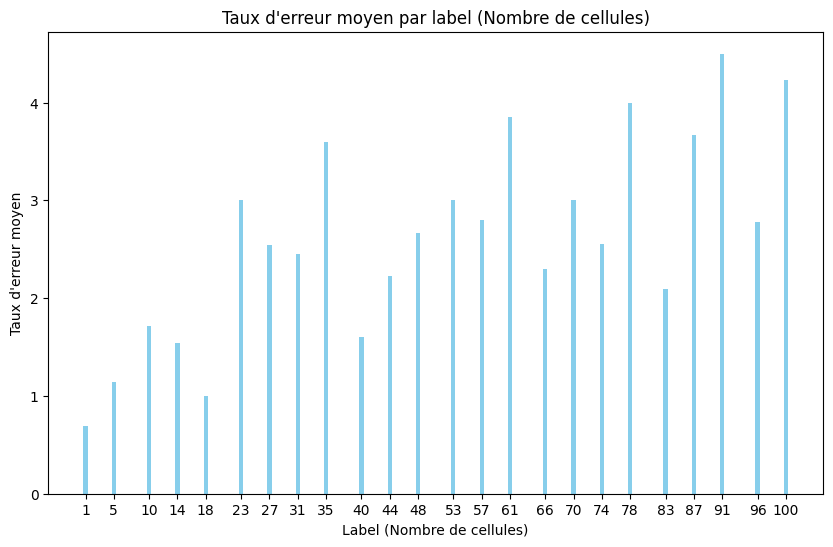

In [31]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def plot_error_rate_by_label(model_path, model, data_loader, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()  # Passer le modèle en mode évaluation

    # Dictionnaire pour stocker les erreurs par label
    errors_by_label = {}

    # Calcul des erreurs pour chaque image
    with torch.no_grad():
        for images, labels, _ in data_loader:
            images, labels = images.to(device), labels.to(device)

            # Prédiction du modèle
            outputs = model(images)

            # Arrondir les prédictions à l'entier le plus proche
            rounded_outputs = torch.round(outputs.squeeze())

            # Calcul des erreurs
            errors = torch.abs(rounded_outputs - labels.float())  # Erreur absolue entre prédiction arrondie et label

            # Enregistrer les erreurs par label
            for label, error in zip(labels.cpu().numpy(), errors.cpu().numpy()):
                if label.item() not in errors_by_label:
                    errors_by_label[label.item()] = []
                errors_by_label[label.item()].append(error)

    # Calcul du taux d'erreur moyen par label
    avg_errors_by_label = {label: np.mean(errors) for label, errors in errors_by_label.items()}

    # Tracer l'histogramme
    labels = list(avg_errors_by_label.keys())
    avg_errors = list(avg_errors_by_label.values())

    plt.figure(figsize=(10, 6))
    plt.bar(labels, avg_errors, width=0.6, color='skyblue')
    plt.xlabel('Label (Nombre de cellules)')
    plt.ylabel('Taux d\'erreur moyen')
    plt.title('Taux d\'erreur moyen par label (Nombre de cellules)')
    plt.xticks(labels)
    plt.show()

# Exemple d'utilisation avec un modèle et un DataLoader de test
plot_error_rate_by_label('model.pt', capsule_net, test_loader)


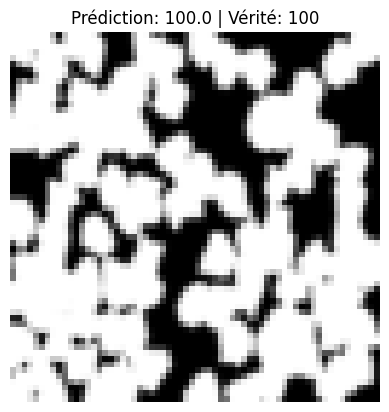

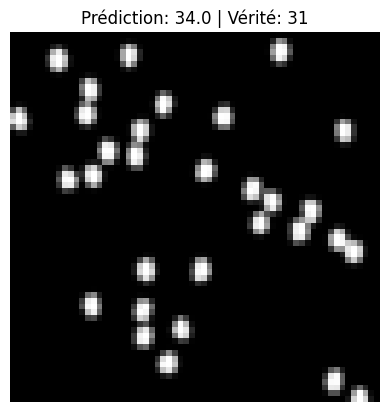

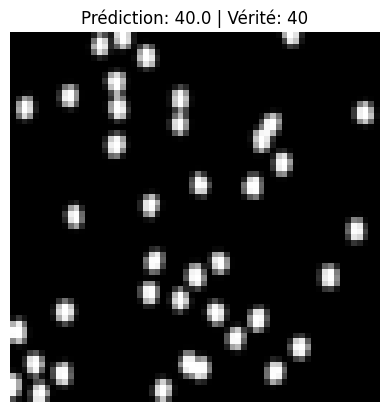

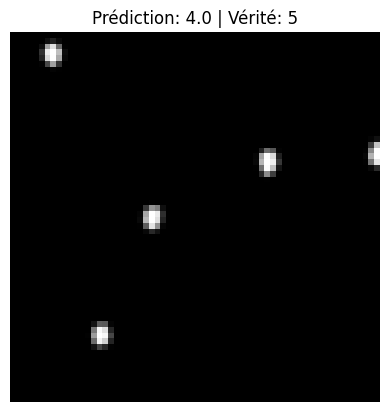

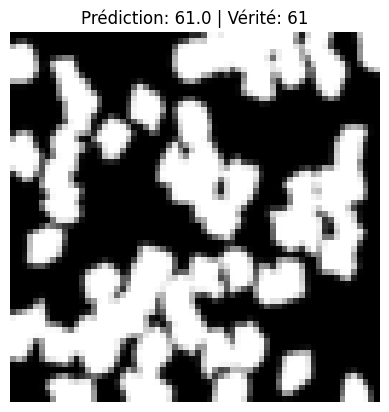

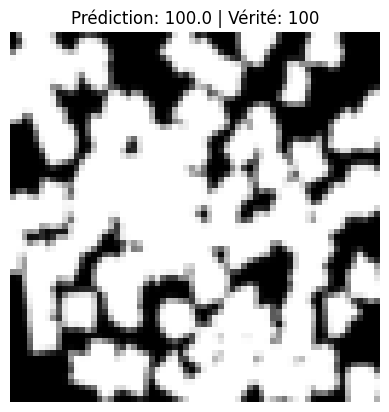

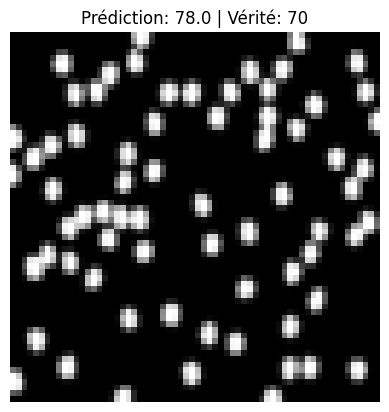

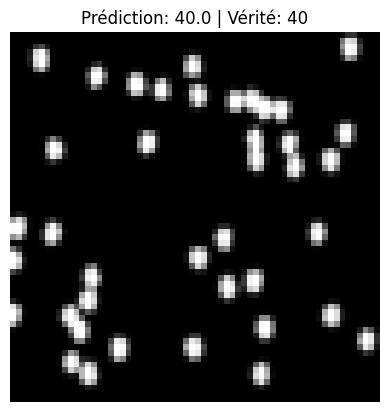

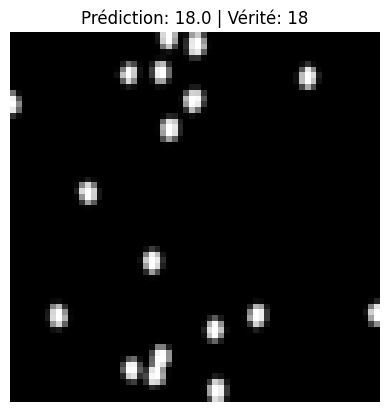

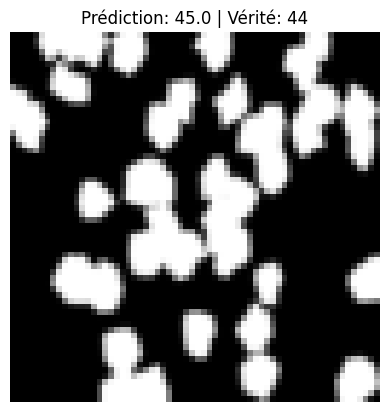

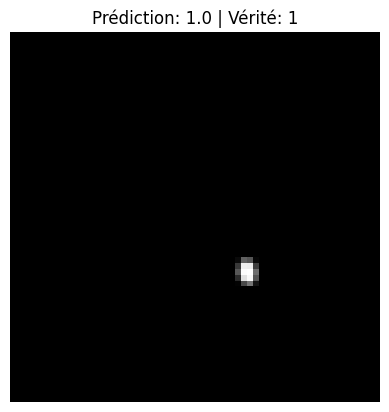

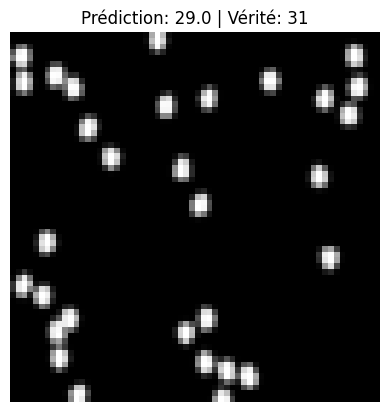

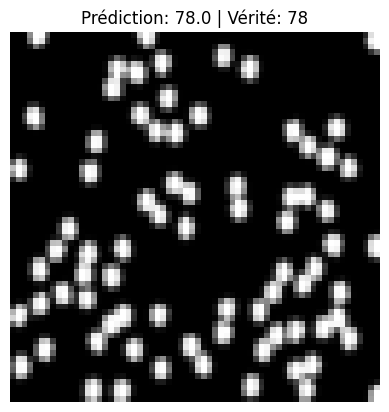

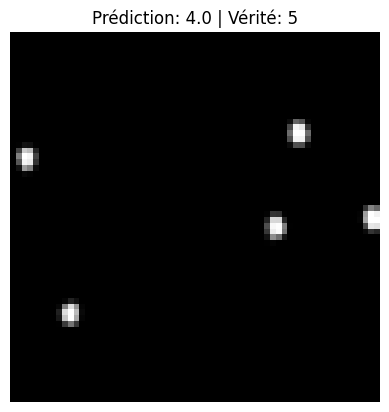

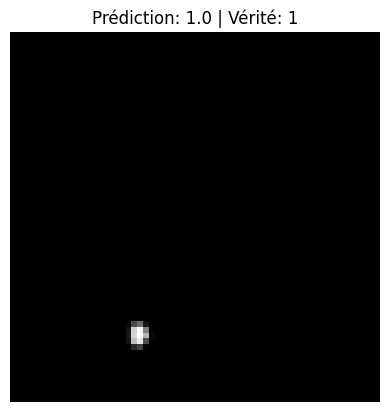

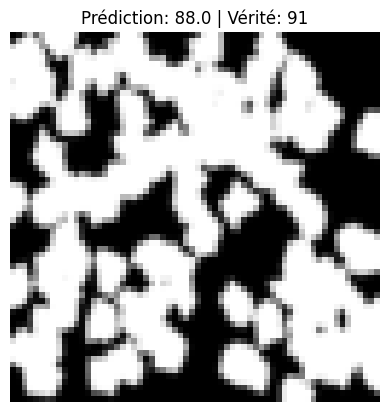

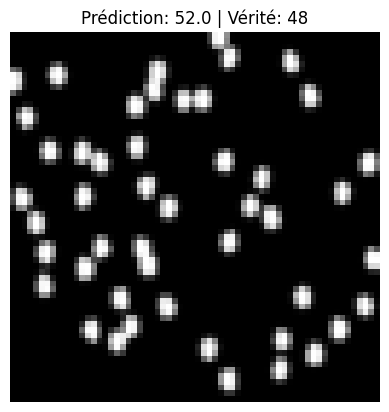

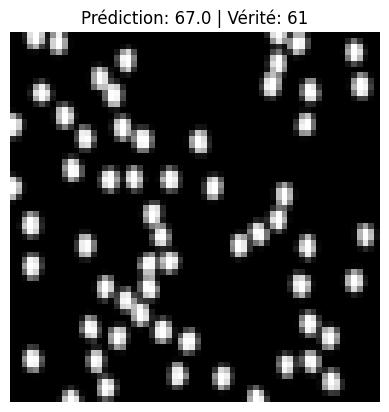

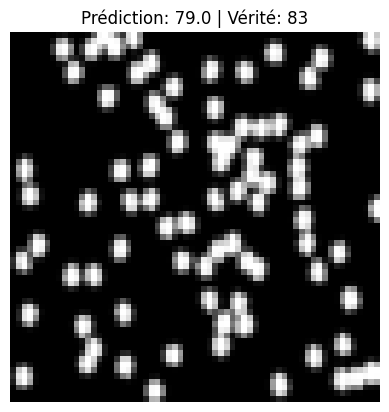

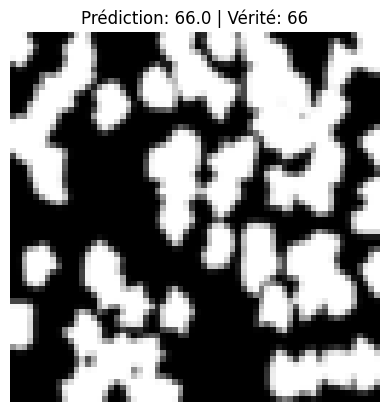

In [ ]:
import matplotlib.pyplot as plt
import torch

def show_predictions(model, data_loader, device='cuda' if torch.cuda.is_available() else 'cpu', num_samples=20):
    model.eval()  # Passer le modèle en mode évaluation
    images_shown = 0

    with torch.no_grad():  # Pas de calcul des gradients
        for images, labels,filename in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)  # Prédictions du modèle

            # Arrondir les prédictions à l'entier le plus proche
            rounded_predictions = torch.round(outputs.squeeze())

            # Afficher les 10 premières prédictions
            for i in range(min(num_samples, len(images))):
                image = images[i].cpu().squeeze().numpy()  # Récupérer l'image (et la convertir en numpy)
                label = labels[i].item()  # Le vrai label
                prediction = rounded_predictions[i].item()  # La prédiction arrondie

                # Affichage de l'image et des informations
                plt.imshow(image, cmap='gray')
                plt.title(f"Prédiction: {prediction} | Vérité: {label}")
                plt.axis('off')
                plt.show()

                images_shown += 1
                if images_shown >= num_samples:
                    return

# Appeler la fonction
show_predictions(capsule_net, test_loader)
